In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1.2,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\Ai-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 10, Accuracy: 0.8765432098765432, Loss: 0.43600195425528065
Checkpoint 20, Accuracy: 0.9012345679012346, Loss: 0.3996926060429326
Checkpoint 30, Accuracy: 0.9135802469135802, Loss: 0.39085289284035013
Checkpoint 40, Accuracy: 0.9197530864197531, Loss: 0.32674001764368127
Checkpoint 50, Accuracy: 0.9382716049382716, Loss: 0.299094765274613
Checkpoint 60, Accuracy: 0.9444444444444444, Loss: 0.23495614087140118
Checkpoint 70, Accuracy: 0.9567901234567902, Loss: 0.2010883578547725
Checkpoint 80, Accuracy: 0.9567901234567902, Loss: 0.18547955265751592
Checkpoint 90, Accuracy: 0.9629629629629629, Loss: 0.17877960205078125
Checkpoint 100, Accuracy: 0.9691358024691358, Loss: 0.1468026284818296
Checkpoint 110, Accuracy: 0.9691358024691358, Loss: 0.12941047880384657
Checkpoint 120, Accuracy: 0.9629629629629629, Loss: 0.12617840590300383
Checkpoint 130, Accuracy: 0.9629629629629629, Loss: 0.11258746959544995
Checkpoint 140, Accuracy: 0.9691358024691358, Loss: 0.1175081729888916
Checkpo

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

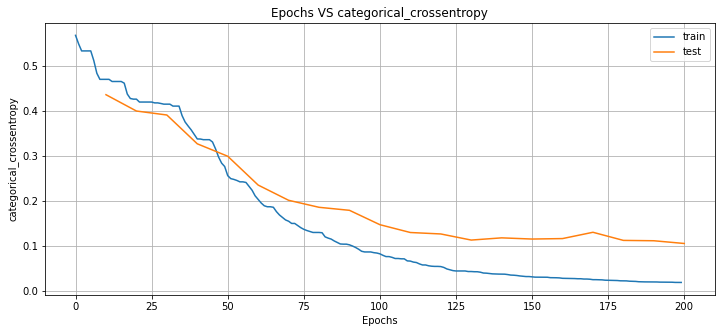

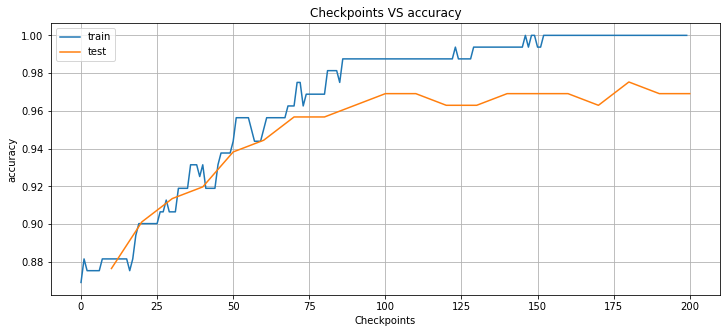

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [1.4759994e-01 8.5214019e-01 2.5983292e-04]
[0. 0. 1.] <-> [0.53912467 0.00324096 0.45763445]
[0. 1. 0.] <-> [8.5552577e-03 9.9142456e-01 2.0188241e-05]
[0. 0. 1.] <-> [1.9812714e-02 3.0742306e-04 9.7987980e-01]
[1. 0. 0.] <-> [0.9820456  0.00234735 0.01560702]
[1. 0. 0.] <-> [0.9400159  0.00344233 0.05654181]
[1. 0. 0.] <-> [0.12413746 0.00113739 0.87472516]
[1. 0. 0.] <-> [0.99659485 0.00143457 0.00197061]
[1. 0. 0.] <-> [9.9767607e-01 9.2259998e-04 1.4013933e-03]
[1. 0. 0.] <-> [0.9968156  0.00138219 0.00180218]
[1. 0. 0.] <-> [0.9932046  0.00572648 0.00106886]
[1. 0. 0.] <-> [0.9974837  0.00108779 0.00142857]
[1. 0. 0.] <-> [0.9736443  0.02533818 0.00101741]
[1. 0. 0.] <-> [9.9807405e-01 9.8718621e-04 9.3876326e-04]
[1. 0. 0.] <-> [0.9969823  0.00114362 0.00187409]
[1. 0. 0.] <-> [0.72972804 0.26917833 0.00109366]
[1. 0. 0.] <-> [0.9968207  0.00208431 0.001095  ]
[1. 0. 0.] <-> [0.997514   0.00146637 0.00101968]
[0. 1. 0.] <-> [8.5196691e-03 9.9146044e-01 1.9866970e-

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8765432098765432, 'mean_square_error': 0.26446848464521394, 'categorical_crossentropy': 0.43600195425528065, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 19, 'tn_hit': 11, 'fn_hit': 1}, 1: {'tp_hit': 7, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 9}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 10}}, 'checkpoint': 10} 


{'accuracy': 0.9012345679012346, 'mean_square_error': 0.22689583393504897, 'categorical_crossentropy': 0.3996926060429326, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 12, 'tn_hit': 18, 'fn_hit': 4}, 1: {'tp_hit': 12, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 4}, 2: {'tp_hit': 6, 'fp_hit': 2, 'tn_hit': 92, 'fn_hit': 8}}, 'checkpoint': 20} 


{'accuracy': 0.9135802469135802, 'mean_square_error': 0.21415293225878582, 'categorical_crossentropy': 0.39085289284035013, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 10, 'tn_hit': 20, 'fn_hit': 4}, 1: {'tp_hit': 12, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 4}, 2: {'tp_hit': 8, 'fp_hit': 2, 'tn_hit': 92, 'f

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-1.9183961  2.863696   3.         0.3794336 -0.9128889]
 bias: -2.1935200691223145

Neuron 1: weights:
[ 2.3852844  -3.         -3.         -1.8859147   0.96455145]
 bias: 2.2554235458374023

Neuron 2: weights:
[-0.5165051  3.         3.        -0.6185749 -3.       ]
 bias: 3.0

Neuron 3: weights:
[ 0.09121122  3.         -0.8721184  -0.65796167 -3.        ]
 bias: 2.3755807876586914

$
Layer 2
Neuron 0: weights:
[-3.         3.         2.6276598  3.       ]
 bias: -2.558619737625122

Neuron 1: weights:
[ 3.         -3.          0.14105284  2.3483543 ]
 bias: -0.6641572117805481

Neuron 2: weights:
[-3.         1.8032322 -3.        -3.       ]
 bias: 3.0

$

